In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [5]:
with open("data/user-wallet-transactions.json", "r") as f:
    data = json.load(f)

In [42]:
data[0]



{'_id': {'$oid': '681d38fed63812d4655f571a'},
 'userWallet': '0x00000000001accfa9cef68cf5371a23025b6d4b6',
 'network': 'polygon',
 'protocol': 'aave_v2',
 'txHash': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190',
 'logId': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit',
 'timestamp': 1629178166,
 'blockNumber': 1629178166,
 'action': 'deposit',
 'actionData': {'type': 'Deposit',
  'amount': '2000000000',
  'assetSymbol': 'USDC',
  'assetPriceUSD': '0.9938318274296357543568636362026045',
  'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174',
  'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'},
 '__v': 0,
 'createdAt': {'$date': '2025-05-08T23:06:39.465Z'},
 'updatedAt': {'$date': '2025-05-08T23:06:39.465Z'}}

In [46]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(random_state=42)

In [48]:
import pickle 

with open("avve_credit.pkl", "wb") as f:
	pickle.dump(rfc, f)

In [17]:
def normalize_amount(amount_str, decimals=6):
    return float(amount_str) / (10 ** decimals)

In [ ]:
from collections import defaultdict

def process_wallets_from_df(df):
    wallet_stats = defaultdict(lambda: {
        "total_deposit": 0,
        "total_borrow": 0,
        "total_repay": 0,
        "num_liquidations": 0
    })

    for _, row in df.iterrows():
        wallet = row["userWallet"]
        action = row["action"]
        amount_raw = row.get("actionData.amount", "0")
        price_usd = float(row.get("actionData.assetPriceUSD", 1))

        amount = normalize_amount(amount_raw)
        usd_value = amount * price_usd

        if action == "deposit":
            wallet_stats[wallet]["total_deposit"] += usd_value
        elif action == "borrow":
            wallet_stats[wallet]["total_borrow"] += usd_value
        elif action == "repay":
            wallet_stats[wallet]["total_repay"] += usd_value
        elif action == "liquidationcall":
            wallet_stats[wallet]["num_liquidations"] += 1

    return wallet_stats

In [ ]:
def calculate_score(stats):
    scores = []
    for wallet, s in stats.items():
        score = 500  
        repay_ratio = s["total_repay"] / s["total_borrow"] if s["total_borrow"] else 1

        if repay_ratio > 0.95:
            score += 300
        elif repay_ratio > 0.75:
            score += 150
        elif repay_ratio < 0.5:
            score -= 100

        if s["num_liquidations"] > 0:
            score -= 100 * s["num_liquidations"]

        if s["total_deposit"] > s["total_borrow"]:
            score += 50

        score = max(0, min(score, 1000))
        scores.append({"wallet": wallet, "score": int(score)})

    return scores

In [28]:
def save_scores(scores, out_path="wallet_scores.csv"):
    df = pd.DataFrame(scores)
    df.to_csv(out_path, index=False)

In [30]:
print("Processing wallet stats...")
stats = process_wallets_from_df(df)

print("Calculating scores...")
scores = calculate_score(stats)

print("Saving to CSV...")
save_scores(scores)
print("Done.")

Processing wallet stats...
Calculating scores...
Saving to CSV...
Done.


In [ ]:
def categorize_wallet(row):
    if row['total_borrowed'] > 0 and row['total_repaid'] / row['total_borrowed'] > 0.95 and row['num_liquidations'] == 0:
        return 'Good Borrower'
    elif row['total_borrowed'] > 0 and row['num_liquidations'] > 0:
        return 'Liquidated/Suspicious'
    elif row['total_borrowed'] == 0 and row['num_deposits'] > 0:
        return 'Depositor Only'
    else:
        return 'Other'

features_df['category'] = features_df.apply(categorize_wallet, axis=1)

category_counts = features_df['category'].value_counts()



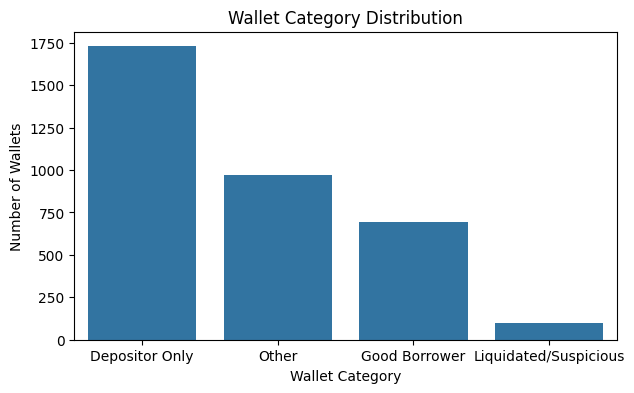

In [ ]:
plt.figure(figsize=(7,4))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.ylabel('Number of Wallets')
plt.xlabel('Wallet Category')
plt.title('Wallet Category Distribution')
plt.show()

In [34]:
print("Category counts:")
print(category_counts)
print("\nScore ranges by category:")
for cat in category_counts.index:
    scores = features_df[features_df['category'] == cat]['score']
    print(f"{cat}: min={scores.min()}, max={scores.max()}, mean={scores.mean():.1f}")

Category counts:
category
Depositor Only           1728
Other                     973
Good Borrower             695
Liquidated/Suspicious     101
Name: count, dtype: int64

Score ranges by category:
Depositor Only: min=500, max=500, mean=500.0
Other: min=400, max=600, mean=428.0
Good Borrower: min=700, max=700, mean=700.0
Liquidated/Suspicious: min=0, max=600, mean=266.3


In [45]:
df = pd.read_csv("wallet_scores.csv")

# Step 1: Define bins and labels correctly
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000.1]  # Add small buffer for 1000
labels = ["0-100", "101-200", "201-300", "301-400", "401-500", 
          "501-600", "601-700", "701-800", "801-900", "901-1000"]

# Step 2: Assign score ranges
df['score_range'] = pd.cut(df['score'], bins=bins, labels=labels, right=False)

# Step 3: Count wallet scores in each range
distribution = df['score_range'].value_counts().sort_index()

# Step 4: Print as markdown table for analysis.md
print("| Score Range | Wallet Count |")
print("|-------------|---------------|")
for range_label, count in distribution.items():
    print(f"| {range_label} | {count} |")


| Score Range | Wallet Count |
|-------------|---------------|
| 0-100 | 12 |
| 101-200 | 8 |
| 201-300 | 21 |
| 301-400 | 31 |
| 401-500 | 694 |
| 501-600 | 92 |
| 601-700 | 12 |
| 701-800 | 78 |
| 801-900 | 2406 |
| 901-1000 | 0 |
